This notebook uses the q_learning_lib.py to perform Q-learning on tic tac toe.

A variation of different hyperparameters are tried, against many different cases.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import q_learning_lib as qlb
import json
import os

Assuming alpha = 0.1 and tau = e, lets record what happens in each of the 4 cases of training (optimal, non optimal, x, o)

In [ ]:
NUMBER_OF_BATCHES = 1000
BATCH_SIZE = 10

In [3]:
def make_alpha(rate_val):
    """Function factorie for creating different alpha functions"""
    def alpha(turn):

        #return rate_val * (BATCH_SIZE * NUMBER_OF_BATCHES - turn) / (NUMBER_OF_BATCHES * BATCH_SIZE)
        return 0.5 / (1 + rate_val * turn) 

    return alpha

def make_tau(rate_val):
    """Function factorie for creating different tau functions"""
    def tau(turn):
        #return 1 + rate_val * (turn) / (NUMBER_OF_BATCHES * BATCH_SIZE) 
        return 1 + (rate_val - 1) * ((turn/(NUMBER_OF_BATCHES * BATCH_SIZE))**3)
    return tau

def record_params(results, filename):

    df = pd.DataFrame(results[::-1], columns=['o_win', 'draw', 'x_win'])

    # Save to CSV (index=False prevents it from adding a row-number column)
    df.to_csv(filename, index=False)

In [4]:
alpha_rates = np.linspace(0.00000001, 0.0005, 10)
tau_values = np.linspace(1000, 10000000, 10)
tau_values

array([1.000e+03, 1.112e+06, 2.223e+06, 3.334e+06, 4.445e+06, 5.556e+06,
       6.667e+06, 7.778e+06, 8.889e+06, 1.000e+07])

In [5]:
def try_different_hyperparams(alpha_rates, tau_values, player, strategy, folder=""):
    """this functions tries a variation of different hyperparameters
    results from every single iteration are saved in a .csv file
    how alpha params, tau values affect the final winrates is recorded in a pandas df and also saved to a file """
 
    df_list = [] #will be turned to a df later
    
    for a, alpha_rate in enumerate(alpha_rates): 
        for b, tau_value in enumerate(tau_values):

            #trains
            Q_Table_x_optimal, results = qlb.perform_training(player, strategy, NUMBER_OF_BATCHES, BATCH_SIZE, False, make_alpha(alpha_rate), make_tau(tau_value))

            results = results/(BATCH_SIZE * 200)
        
            #records the results
            filename = f"parameter_results/{player}_vs_{strategy}/_opponent_alpha_{alpha_rate}_tau_{tau_value}.csv"
            record_params(results, filename)

            
            #records end winrates vs hyperparams
            o_winrate = np.mean(results[:, 0][-5:])
            drawrate = np.mean(results[:, 1][-5:])
            x_winrate = np.mean(results[:, 2][-5:])
            new_results = {'alpha_rate': alpha_rate, 'tau_rate': tau_value, 'o_winrate': o_winrate, 'drawrate': drawrate, 'x_winrate': x_winrate}
            df_list.append(new_results)
            #print(f"alpha rate = {alpha_rate}, tau rate = {tau_value}, end winrates = {end_winrate}")
            print(f"{player}_vs_{strategy}: {((a * 10 + b + 1)/(len(alpha_rates) * len(tau_values))) * 100:.2f}%")
            print(f"'alpha_rate' {alpha_rate}, 'tau_rate': {tau_value}, 'o_winrate': {o_winrate:.3f}, 'drawrate': {drawrate:.3f}, 'x_winrate': {x_winrate:.3f}")

    df = pd.DataFrame(df_list) 
    df.to_csv(f"parameter_results/{player}_vs_{strategy}/hyperparams.csv", index=False)

In [19]:
try_different_hyperparams(alpha_rates, tau_values, 'x', 'perfect')


OSError: Cannot save file into a non-existent directory: 'parameter_results/x_vs_perfect'

In [17]:
df = pd.read_csv('parameter_results/analysis_3/x_vs_perfect/hyperparams.csv')

Text(0.5, 1.0, 'Max drawrate achieved 100.00%')

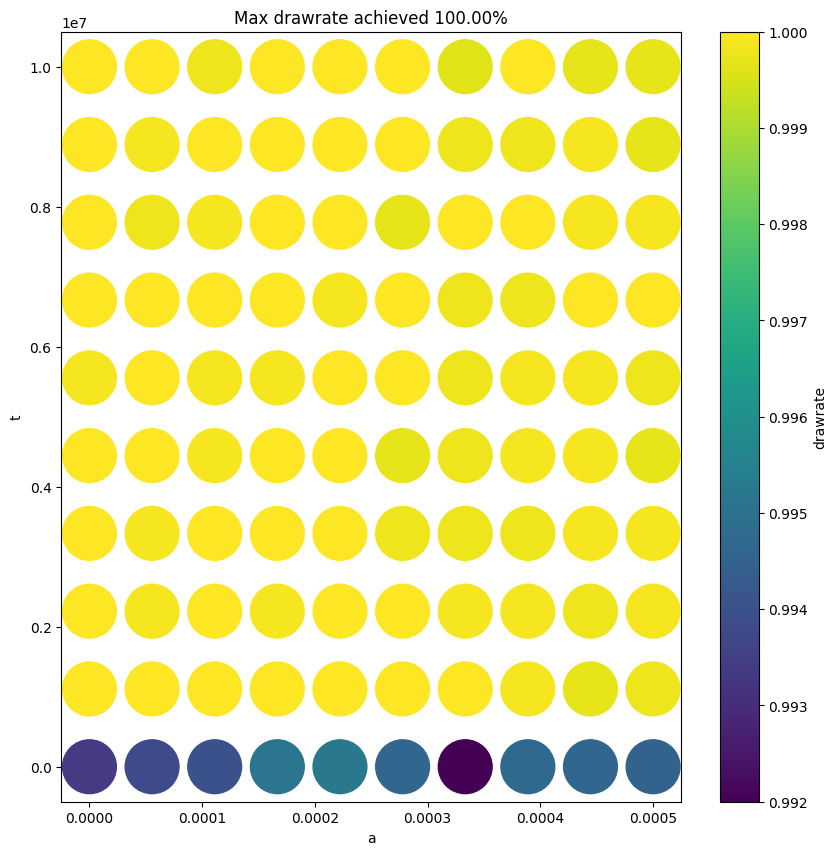

In [18]:
# 1. Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

mask = df

x = mask['alpha_rate']
y = mask['tau_rate']
z = mask['drawrate']

# 2. Capture the return value (the "mappable")
scatter = ax.scatter(x, y, c=z, s=1500, cmap='viridis') # cmap is optional but recommended

# 3. Pass the scatter object to the colorbar
fig.colorbar(scatter, ax=ax, label=z.name)
ax.set_xlabel('a')
ax.set_ylabel('t')
ax.set_title(f"Max {z.name} achieved {z.max() * 100 :.2f}%")

In [9]:
def varyas_tau(turn):
    return 1 + turn/1000

def varyas_alpha(turn):
    return 0.1

In [10]:
Q_Table, results = qlb.perform_training('x', 'perfect', 10000, 10, True, varyas_alpha, varyas_tau)

o win   draw    x win
200
76.85%   23.15%   0.00%
400
70.55%   29.45%   0.00%
600
58.55%   41.45%   0.00%
800
48.85%   51.15%   0.00%
1000
41.10%   58.90%   0.00%
1200
34.90%   65.10%   0.00%
1400
30.40%   69.60%   0.00%
1600
25.35%   74.65%   0.00%
1800
25.25%   74.75%   0.00%
2000
22.25%   77.75%   0.00%
2200
20.20%   79.80%   0.00%
2400
16.65%   83.35%   0.00%
2600
16.45%   83.55%   0.00%
2800
15.20%   84.80%   0.00%
3000
13.20%   86.80%   0.00%
3200
14.20%   85.80%   0.00%
3400
13.65%   86.35%   0.00%
3600
13.35%   86.65%   0.00%
3800
11.10%   88.90%   0.00%
4000
10.70%   89.30%   0.00%
4200
10.95%   89.05%   0.00%
4400
11.30%   88.70%   0.00%
4600
10.45%   89.55%   0.00%
4800
9.45%   90.55%   0.00%
5000
8.55%   91.45%   0.00%
5200
8.25%   91.75%   0.00%
5400
8.00%   92.00%   0.00%
5600
7.60%   92.40%   0.00%
5800
8.25%   91.75%   0.00%
6000
7.40%   92.60%   0.00%
6200
6.90%   93.10%   0.00%
6400
6.75%   93.25%   0.00%
6600
6.30%   93.70%   0.00%
6800
7.05%   92.95%   0.00%
7000
7.

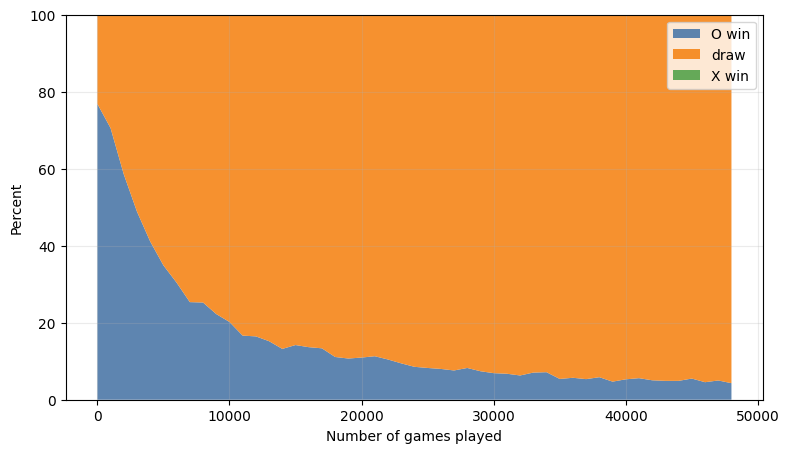

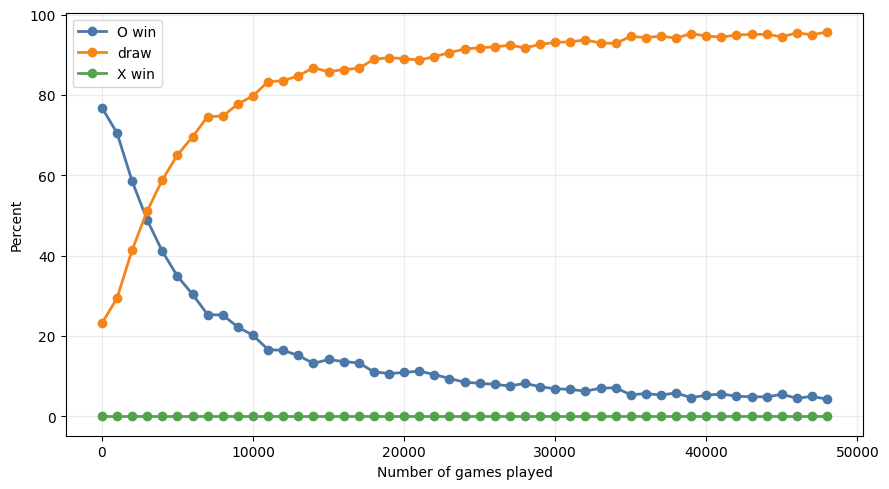

In [11]:
qlb.plot_triplet_ratios(results, 10)